### EnKF vs EnRF Lorenz 63

In [1]:
using Revise
using LinearAlgebra
using TransportBasedInference
using Statistics
using Distributions
using RobustFilter
using PDMats

[ Info: Precompiling RobustFilter [cc3c39f0-f0fc-4708-9ae7-d61ed5bdbe0e]


Load some packages to make nice figures

In [2]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# pyplot()
using LaTeXStrings
# PyPlot.rc("text", usetex = "true")
# PyPlot.rc("font", family = "CMU Serif")
using ColorSchemes
using NamedColors

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(\boldsymbol{x}, t) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [3]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [4]:
Δtdyn = 0.05
Δtobs = 0.1

0.1

Define the time span of interest

In [5]:
t0 = 0.0
tf = 600.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

6000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [6]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the system of ODEs to solve. For a system of ODEs, we will prefer the in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model used in `OrdinaryDiffEq`. With this package, we integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method with an adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

Note: the right-hand-side of the Lorenz-63 model is implemented in `TransportBasedInference` under the name `lorenz63!`. The code is reproduced for convenience.

```
function lorenz63!(du,u,p,t)
    du[1] = 10.0*(u[2]-u[1])
    du[2] = u[1]*(28.0-u[3]) - u[2]
    du[3] = u[1]*u[2] - (8/3)*u[3]
    return du
end
```

In [92]:
H = Matrix(1.0*I, 3,3)
h(x, t) = x[1:3]
F = StateSpace(lorenz63!, h)

StateSpace(TransportBasedInference.lorenz63!, TransportBasedInference.var"#24#25"(), h)

`ϵx` defines the additive process noise applied between the forecast step and the analysis step. The process noise is applied before to sample from the likelihood model.

`ϵy` defines the additive observation noise. 

We assume that the noise distributions are Gaussian.

In [93]:
σx = 1e-2
σy = 1.0
νy = 3.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = TDistAdditiveInflation(Ny, Distributions.GenericMvTDist(νy, zeros(Ny), PDiagMat(σy^2*ones(Ny))))

TDistAdditiveInflation(3, Distributions.GenericMvTDist{Float64, PDiagMat{Float64, Vector{Float64}}, Vector{Float64}}(
df: 3.0
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)
)

Different types of inflation have been implemented in `TransportBasedInference`:
        
* `IdentityInflation` applies the identity transformation
* `AdditiveInflation` applies Gaussian noise to the ensemble members
* `MultiplicativeInflation` increases the spread of the ensemble  about the sample mea by a multiplicative factor $\beta$.
* `MultiAddInflation` combine a multiplicative and an additive inflation.

They are all subtypes of the abstract type `InflationType`.

New types of inflation can easily be created and integrated in the existing tools of `TransportBasedInference`, as long as the satisfy the following requirements: 

* `MyInflationType <: InflationType` 
* `(A::MyInflationType)(X::AbstractMatrix{Float64})` is defined

In [94]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

Set initial condition of the true system

In [95]:
x0 = rand(model.π0)

3-element Vector{Float64}:
 -0.29743587633586244
  0.9180187529023303
  0.388176687656562

Run dynamics and generate data

For the twin-experiment, we use the function `generate_lorenz63` to integrate forward in time the Lorenz-63 ODE, and generate the observations that will be later assimilated in the ensemble filter. This function can easily be modified for your specific needs.

In [96]:
data = generate_data(model, x0, Tf);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [97]:
νYXestimated = regularized_EM_tdist_search(vcat(data.yt, data.xt), 0.5/sqrt(size(data.xt,2)), 2.5:0.5:20.0)[end]

5.0

In `TransportBasedInference`, we use the following convention to store the state and observation variables. The state and observation variables of the different ensemble members are stored in a common matrix `X`. The different columns store the different samples. The first entries of a column contains the observation variables, while the latter contains the state variables. This convention might seem confusing at first, but it is very convenient for conditional density estimation, see notebook 2 or 5 for instance.

Different ensemble filters have been implemented in `TransportBasedInference`:
        
* `IdFilter`: a trivial identity filter

* `StochEnKF`: the stochastic version of the ensemble Kalman filter (sEnKF), Evensen [1].

* `ETKF`: the ensemble transform Kalman filter (ETKF) Bishop et al. [3]. This filter exactly verifies the propagation equation for the covariance matrix of the Kalman filter, and avoid to sample the observation noise. This filter belongs to the class of deterministic ensemble Kalman filters.

* `StochMapFilter`: the stochastic map filter (SMF) developed by Spantini et al. [5]. This filter is a nonlinear generalization of the stochastic EnKF based on measure transport. This filter is presented in the notebooks 6 & 7.

New ensemble filter can easily be created and integrated in the existing tools of `TransportBasedInference`, as long as they satisfy the following requirements: 

* `MyFilterType <: SeqFilter` 
* `(A::MyFilterType)(X::AbstractMatrix{Float64}, ystar, t)` is defined, where `ystar` is the observation to assimilate in the forecast ensemble `X`.

Define a stochastic ensemble Kalman filter

In [98]:
enkf = LiksEnKF(model.ϵy, model.Δtdyn, model.Δtobs)

Likelihood-based sEnKF with filtered = false


In [162]:
β = 1.00

1.0

In [163]:
ϵxβ = MultiAddInflation(Nx, β, zeros(Nx), σx)

MultiAddInflation(3, 1.0, [0.0, 0.0, 0.0], [0.0001 0.0 0.0; 0.0 0.0001 0.0; 0.0 0.0 0.0001], [0.01 0.0 0.0; 0.0 0.01 0.0; 0.0 0.0 0.01])

Define an instance of the ensemble robust filter

In [164]:
νYXgrid = 2.5:0.5:20.0

2.5:0.5:20.0

In [165]:
enkf_lasso = LikEnKFLasso(model.ϵy, model.Δtdyn, model.Δtobs; rtol = 1e-2, ρ_scaling = [0.5])

Likelihood-based Lasso EnKF  with filtered = false


In [166]:
enrf_large = LikEnRFLasso(model.ϵy, model.Δtdyn, model.Δtobs, 1e7*model.Δtobs; estimate_dof = false,
                                                                    rtol = 1e-2, 
                                                                    νYX = [100], 
                                                                    ρ_scaling = [0.5],
                                                                    νYXgrid = νYXgrid)

Likelihood-based Lasso EnRF  with filtered = false and estimate dof = false


In [167]:
enrf_fixed = LikEnRFLasso(model.ϵy, model.Δtdyn, model.Δtobs, 1e7*model.Δtobs; estimate_dof = false,
                                                                    rtol = 1e-2, 
                                                                    νYX = [5.5], 
                                                                    ρ_scaling = [0.5],
                                                                    νYXgrid = νYXgrid)

Likelihood-based Lasso EnRF  with filtered = false and estimate dof = false


In [168]:
enrf_refresh = LikEnRFLasso(model.ϵy, model.Δtdyn, model.Δtobs, 20*model.Δtobs; estimate_dof = false,
                                                                    rtol = 1e-2, 
                                                                    νYX = [5.5], 
                                                                    ρ_scaling = [0.5],
                                                                    νYXgrid = νYXgrid)

Likelihood-based Lasso EnRF  with filtered = false and estimate dof = false


In [169]:
enrf_adapt = LikEnRFLasso(model.ϵy, model.Δtdyn, model.Δtobs, model.Δtobs; estimate_dof = true,
                                                                    rtol = 1e-2, 
                                                                    νYX = [5.5], 
                                                                    ρ_scaling = [0.5],
                                                                    νYXgrid = νYXgrid)

Likelihood-based Lasso EnRF  with filtered = false and estimate dof = true


Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [171]:
Ne = 500#ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×500 view(::Matrix{Float64}, 4:6, :) with eltype Float64:
  0.436457  -0.207265   0.532306  …  -0.625706   0.36828  -0.511531
  1.13602    0.565722  -0.700982     -0.687939  -3.25645   2.44664
 -0.359423  -0.633153  -0.577183      0.135607  -0.97709   0.510975

Apply the sequential filter over the time window

The function `seqassim` provides a friendly API to experiment with the different ensemble filters, the tuning of the different inflation parameters...

In [177]:
Xenkf = seqassim(F, data, Tf, ϵxβ, enkf, deepcopy(X), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


In [178]:
@time Xenkf_lasso = seqassim(F, data, Tf, ϵx, enkf_lasso, deepcopy(X), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


 22.608224 seconds (282.66 M allocations: 24.136 GiB, 14.26% gc time, 0.25% compilation time)


In [111]:
@time Xenrf_large, νXenrf_large = seqassim_likenrf_tlasso(F, data, Tf, model.ϵx, enrf_large, 
                                                          deepcopy(X), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


  7.477279 seconds (78.49 M allocations: 10.971 GiB, 16.70% gc time)


In [112]:
@time Xenrf_fixed, νXenrf_fixed = seqassim_likenrf_tlasso(F, data, Tf, model.ϵx, enrf_fixed, 
                                                          deepcopy(X), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


  8.886388 seconds (82.86 M allocations: 12.574 GiB, 16.11% gc time)


In [113]:
@time Xenrf_refresh, νXenrf_refresh = seqassim_likenrf_tlasso(F, data, Tf, model.ϵx, enrf_refresh, 
                                                          deepcopy(X), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


 26.903980 seconds (102.70 M allocations: 21.626 GiB, 8.72% gc time)


In [114]:
@time Xenrf_adapt, νXenrf_adapt = seqassim_likenrf_tlasso(F, data, Tf, model.ϵx, enrf_adapt, 
                                                          deepcopy(X), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


 37.982715 seconds (209.19 M allocations: 60.657 GiB, 16.22% gc time)


`mean_hist` stacked together the mean of the ensemble matrices over the assimilation window.

In [174]:
rmse_enkf = mean(map(i->norm(data.xt[:,i]-mean(Xenkf[i+1]; dims = 2))/sqrt(Nx), 4000:Tf))

0.46932355079083116

In [175]:
rmse_enkf_lasso = mean(map(i->norm(data.xt[:,i]-mean(Xenkf_lasso[i+1]; dims = 2))/sqrt(Nx), 4000:Tf))

0.4716199140348955

In [158]:
rmse_enrf_large = mean(map(i->norm(data.xt[:,i]-mean(Xenrf_large[i+1]; dims = 2))/sqrt(Nx), 4000:Tf))

0.4290108207577393

In [159]:
rmse_enrf_fixed = mean(map(i->norm(data.xt[:,i]-mean(Xenrf_fixed[i+1]; dims = 2))/sqrt(Nx), 4000:Tf))

0.35300211240691876

In [160]:
rmse_enrf_refresh = mean(map(i->norm(data.xt[:,i]-mean(Xenrf_refresh[i+1]; dims = 2))/sqrt(Nx), 4000:Tf))

0.36744336414308215

In [161]:
rmse_enrf_adapt = mean(map(i->norm(data.xt[:,i]-mean(Xenrf_adapt[i+1]; dims = 2))/sqrt(Nx), 4000:Tf))

0.3713680760047556

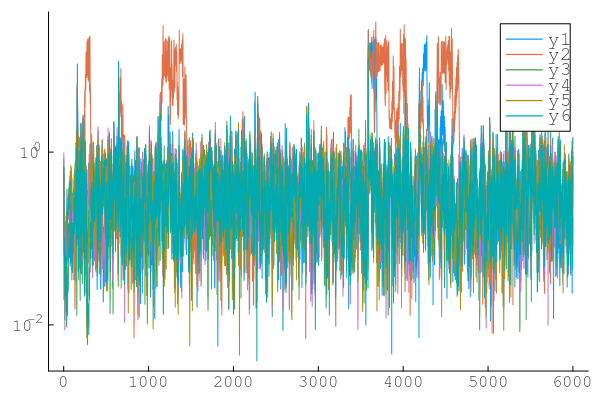

In [121]:
plot(map(i->norm(data.xt[:,i]-mean(Xenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf), yscale = :log10)
plot!(map(i->norm(data.xt[:,i]-mean(Xenkf_lasso[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

plot!(map(i->norm(data.xt[:,i]-mean(Xenrf_large[i+1]; dims = 2))/sqrt(Nx), 1:Tf))
plot!(map(i->norm(data.xt[:,i]-mean(Xenrf_fixed[i+1]; dims = 2))/sqrt(Nx), 1:Tf))
plot!(map(i->norm(data.xt[:,i]-mean(Xenrf_refresh[i+1]; dims = 2))/sqrt(Nx), 1:Tf))
plot!(map(i->norm(data.xt[:,i]-mean(Xenrf_adapt[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

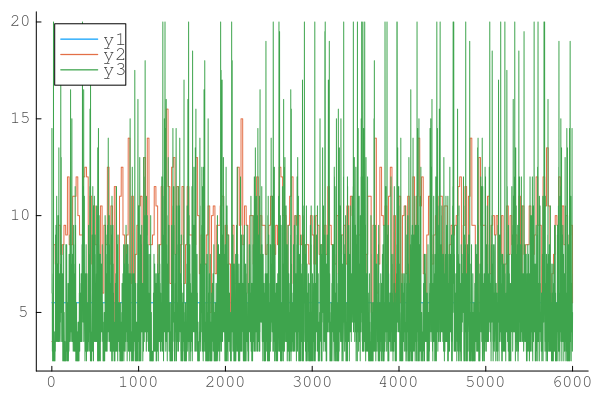

In [91]:
plot(νXenrf_fixed)
plot!(νXenrf_refresh)
plot!(νXenrf_adapt)